# Rozpoznawanie choroby na podstawie objawów

### Wczytanie bibliotek

In [2]:
from idlelib.browser import file_open

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

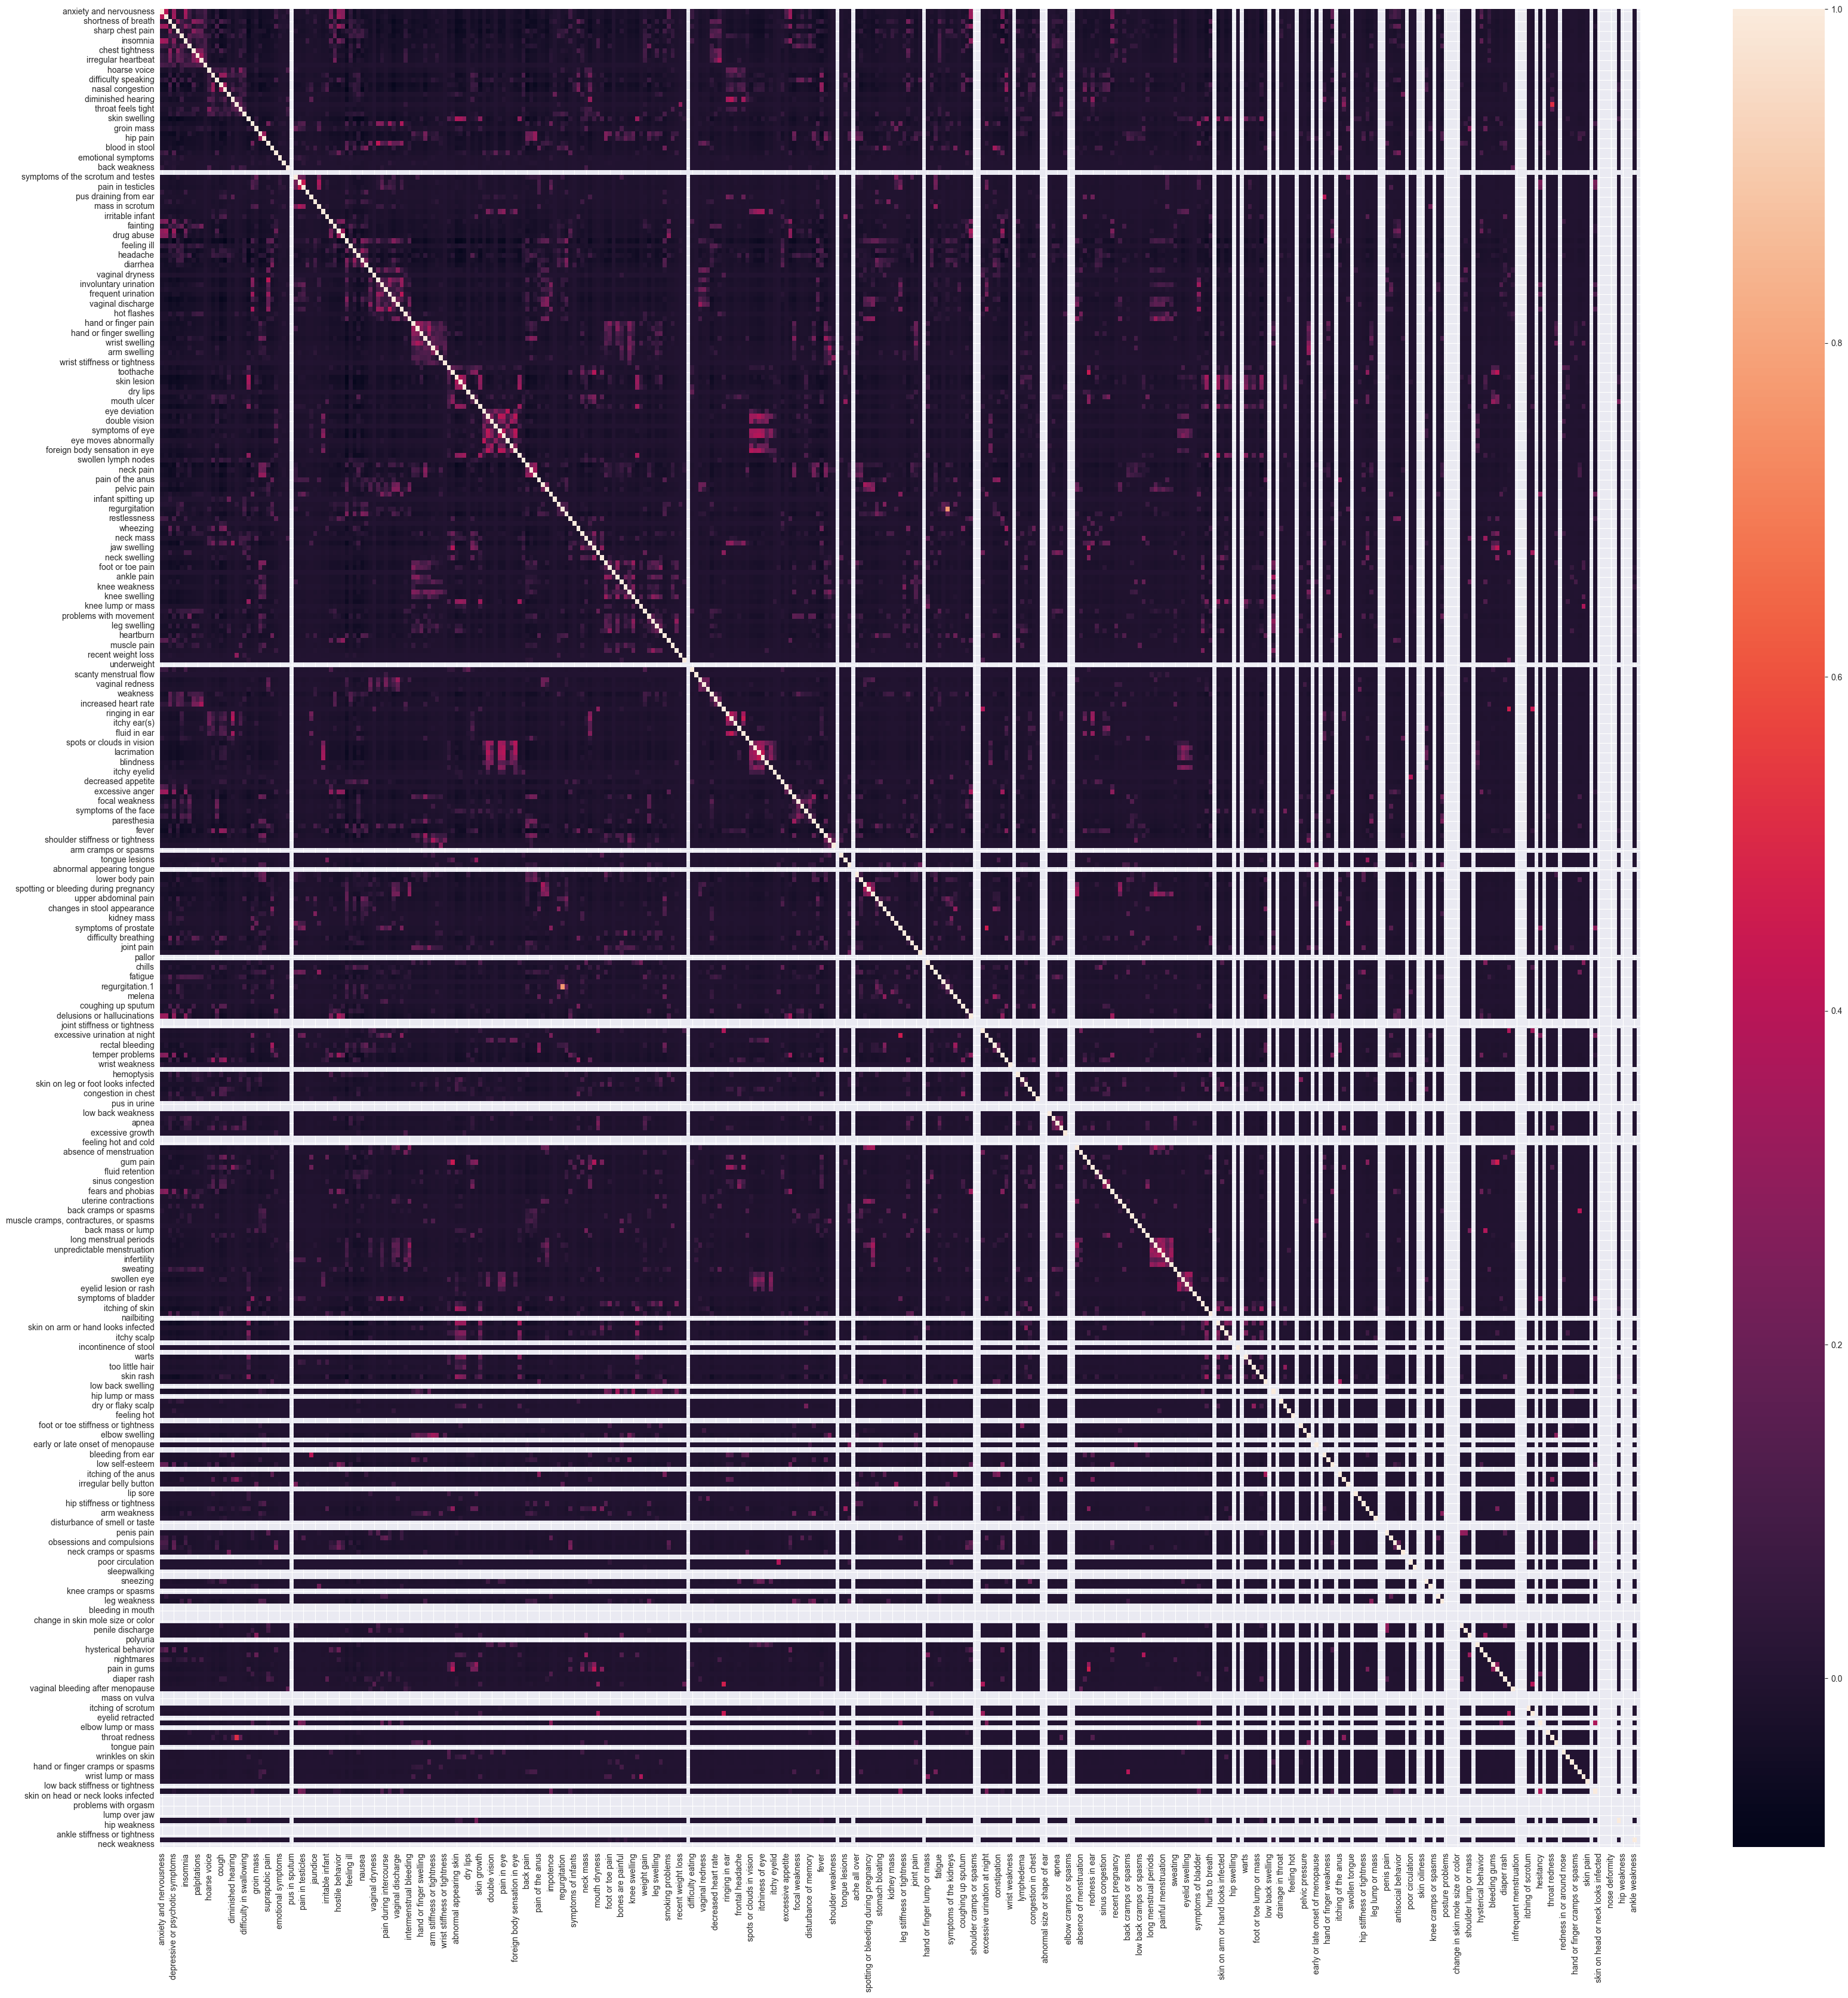